# Extract sentences
We need a verified set of labels and sentences to check model performance against.
- Option 1: Start from the papers that Katherine and Faye reviewed (this is less optimal because we only have codes for 17 UMMZ papers that were manually reviewed. After searching all combined, this only leaves 5 unique codes.)
- Option 2: Search for all formal collections prefixes and find total number of times each is mentioned in combined bibliography. Manually verify a subset of these sentences for UMMZ and USNM model comparison.

Acronyms:
- [Smithsonian](https://www.gbif.org/grscicoll/institution/586ee56e-b0fe-4dff-b7f9-aeb104f3308a) is `USNM` or `NMNH`
- [Michigan](https://www.gbif.org/grscicoll/institution/2a508411-2acd-45df-8a8b-00094ac65f87) is `UMMZ`

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import os
import glob
import json
import re
import random
from tqdm import tqdm
import pysbd
seg = pysbd.Segmenter(language="en", clean=False) # sentence segmenter

In [2]:
def clean_text(txt):
    """
    Removes special characters, punctuation, and returns lowercase
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def clean_text2(txt):
    """
    Removes special characters and punctuation
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def alphanum(txt):
    """
    Extracts alphanumeric characters without spaces
    """
    return "".join(x.lower() for x in txt if x.isalnum())

def extract_pat(search_str:str, search_list:str):
    """
    Defines pattern to search for
    """
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = "None"
    return return_str

def json2txt_df(json_file_path):
    """
    Extract body text of json file
    """
    with open(json_file_path, 'r') as f:
        data = json.loads(f.read())
        body_text_df = pd.json_normalize(data["pdf_parse"]["body_text"])
    
    return body_text_df

def df2sentences(df):
    """
    Tokenize and clean sentences
    """
    sentences_text = " ".join(list(df.text)) 
    pattern_brackets = re.compile(r'\(.*?\)')
    sentences_text = re.sub(pattern_brackets, "", sentences_text) 
    sentences = seg.segment(sentences_text) 
    sentences = [re.sub(r"^\W+", "", sentence) for sentence in sentences] 
    sentences = [re.sub(r"\s+", " ", sentence) for sentence in sentences]
    return sentences

def prep_data(json_file_path, ref_id):
    """
    Return sentence lists for matches
    """
    body_text_df = json2txt_df(json_file_path)
    sentences = df2sentences(body_text_df)
    candidates = []
    for sentence in sentences:
        doc = nlp(sentence)
        matches = matcher(doc)
        if len(matches) > 0:
            sentence_dict = {"text":sentence,
                             "meta":{"ref_id":str(ref_id)}}
            candidates.append(sentence_dict)    
    return candidates

Option 1: Extract column headers from UMMZ codebook (Faye, Katherine versions) as search codes

In [3]:
# df_ummz_1 = pd.read_csv('../labels/manual/Faye_UMMZ.csv',encoding='utf-8')
# names_1 = df_ummz_1.Name.to_list()
# codes_ummz_1 = [i.replace("(", "").replace(")", "").strip() for i in names_1]
# print("UMMZ codes by Faye:",len(codes_ummz_1))

# df_ummz_2 = pd.read_csv('../labels/manual/Katherine_UMMZ.csv',encoding='utf-8')
# names_2 = df_ummz_2.Name.to_list()
# codes_ummz_2 = [i.replace("(", "").replace(")", "").strip() for i in names_2]
# print("UMMZ codes by Katherine:",len(codes_ummz_2))

# combined_codes = codes_ummz_1+codes_ummz_2

# print("All codes:",len(combined_codes))
# codes_pattern = '|'.join(combined_codes)
# codes_pattern

Option 2: Define search pattern using list of acronyms from Cody

In [14]:
df_collections = pd.read_csv('../formal-collection-acronym.csv', skiprows=1)
df_collections = df_collections.dropna(subset=['Formal collection acronym '])
# df_collections = df_collections[df_collections['Formal collection acronym '].notnull()]
df_collections = df_collections[df_collections['Formal collection acronym '] != ' ']
df_collections['Formal collection acronym '] = df_collections['Formal collection acronym '].str.replace('*', '', regex=True)
acronyms = df_collections['Formal collection acronym '].to_list()
acronyms_clean = list(filter(None, acronyms))
acronyms_filter = [str(i).upper() for i in acronyms]
print("Search codes:",len(acronyms_clean))
acronyms_pattern = '|'.join(acronyms_clean)
acronyms_pattern

Search codes: 395


'MACN-Ma|MMHNSR|CNP|IADIZA-CM|MA|MJCM|MLP|MMPMa|MFA-ZV-M|RVP|CUNRC|CML|CRUBM|CBF|MHNNKM|CCBG|MBML|MCN|MHNCI|MZUSP|MN|BPM NHSC|use no acronym|UAMZ|UBC|KM|RBCM|MMMN |RMNP|UMAN|NBM|AUW|NSM|APM|CMN|CUMZ|MNR|RPPMC|ROM|UGDZ|RM|CVUL|RSM|USRC|SSUC|MHNC|MHNV|MNHN|IEEUACH|LCM|MZUC-UCCC|CZIP|ICN|IND-M|UV|MNCR|MZUCR|EPN|MUGM|MECN|QCAZ|MGMC|MHNES|CM-UMSNH|CIB|OAXM|IIBUV|ECO-SC-M|ENCB|MZ-ICACH|CRD|UAY|UAMI|CM-UMSNH|UABSC|FCMM|CNMA|CZRMA|UG|ECOCHM|EB--BUAP|UANL|CPM|INC|CM-MVUP|MNHNP|MUSA|MUSM|NZCS|UWI|MNHN|AUM|USANHC|AFGMC|GBNM|PM|UAM|ASUMC|UA|GRCA Museum Collection|MNA|NAUVM|PFSS|SWRS|WACA|ASUMZ|HSUMZ|UALRVC|UAMZC|CAS|CPSU|CSPUP|CSUC|CSUF|CSULB|CSUN|CSCS|DEVA|DVCM|HSU|LAVO|MPC|MSE|MWFB|LACM|MLZ|PGMNH|PUCNMH|PORE|SBCM\xa0|SDNHM|SDSU|MBM|SBMNH|SJER|MVZ|HNHR|UCLA|YNP|ASCC|COLM|DMNS|DINO|FLC|GSDNM|RMNL|ROMO|UCM|UNC-B|CSUTC|UCONN|YPM|DMNH|UDEL|USNM|ENP|FSUM|FLMNH|GMNH|SSM|BPBM|ACMNH|IDFG|BMR|CHAS|EIU|FMNH|UIMNH|ISM|ISU|RCMC|SIUCM|SIUE|CERL/BIC|WSU|BSUMC|JMM|ISUVC|USI|BVC|CUI|HMNH|ISNHC|PM|SM|ISNHC|IOWA|N

Read in and tokenize sentences from all papers in the combined bibliography

In [5]:
%%time

all_papers = glob.glob('/nfs/turbo/isr-slafia/specimen/build_bibliography_json/*.json')

testing=0

if testing==1:
    all_papers = all_papers[:10] # sample for testing

df_pubs = pd.DataFrame()
for pub_file in all_papers: 
    with open(pub_file, 'r') as f:
        file_name = os.path.basename(pub_file)
        file_id = os.path.splitext(file_name)[0]
        data = json.loads(f.read())
        file_data = pd.json_normalize(data["pdf_parse"]["body_text"])
        file_data["title"] = data["title"]
        file_data["uuid"] = data["paper_id"]
    df_pubs = pd.concat([df_pubs, file_data])

extract_sentences = []

for row in df_pubs.itertuples():
    for sent in seg.segment(row[1]):
        extract_sentences.append((row[8], row[7], row[5], sent))
        
df_sentences = pd.DataFrame(extract_sentences, columns=['uuid', 'title', 'section', 'sent'])
df_sentences['sent'] = df_sentences['sent'].astype(str)
df_sentences.to_csv('/nfs/turbo/isr-slafia/specimen/all_sents.csv',index=False) # this is the TOKENIZED CORPUS

CPU times: user 5min 13s, sys: 750 ms, total: 5min 14s
Wall time: 5min 48s


Search for approved acronyms in all papers
- All
- `UMMZ`
- `UMNH` or `NMNH`

Papers with any approved acronym:  962
All unique acronyms in papers:  138


<AxesSubplot:>

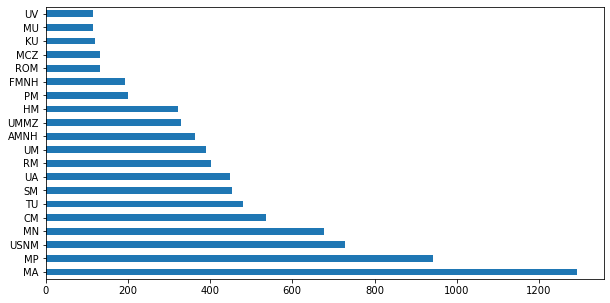

In [12]:
df_sentences = pd.read_csv('/nfs/turbo/isr-slafia/specimen/all_sents.csv') # this is the TOKENIZED CORPUS
df_sentences['acronym'] = df_sentences['sent'].apply(lambda x: extract_pat(search_str=x, search_list=acronyms_pattern))
df_sentences['has_acronym'] = (df_sentences['acronym'] != "None")
df_sentences = df_sentences[(df_sentences.has_acronym==True)]
print("Papers with any approved acronym: ", df_sentences.uuid.nunique())
print("All unique acronyms in papers: ", df_sentences.acronym.nunique())
df_sentences.acronym.value_counts().nlargest(20).plot.barh(figsize=(10,5)); # see 20 most mentioned acronyms

In [17]:
df_ummz = df_sentences[df_sentences.acronym=="UMMZ"]
print("Papers with UMMZ: ", df_ummz.uuid.nunique())
print("Times UMMZ appears in all papers: ", len(df_ummz))

df_usnm = df_sentences[(df_sentences.acronym=="USNM")|(df_sentences.acronym=="NMNH")]
print("Papers with USNM or NMNH: ", df_usnm.uuid.nunique())
print("Times USNM or NMNH appears in all papers: ", len(df_usnm))

df_match = pd.concat([df_ummz,df_usnm]) # combine sentences only for review and validation
df_match.to_csv('/nfs/turbo/isr-slafia/specimen/sentences_ummz_usnm_nmnh.csv',index=False)
df_match.info()

Papers with UMMZ:  129
Times UMMZ appears in all papers:  328
Papers with USNM or NMNH:  125
Times USNM or NMNH appears in all papers:  729
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057 entries, 664 to 306371
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uuid         1057 non-null   object
 1   title        997 non-null    object
 2   section      1023 non-null   object
 3   sent         1057 non-null   object
 4   acronym      1057 non-null   object
 5   has_acronym  1057 non-null   bool  
dtypes: bool(1), object(5)
memory usage: 50.6+ KB


Make a spreadsheet from the combined bibliography that indicates whether a paper has an acronym. Merge on uuid to get metadata records for those papers. Export to CSV to manually verify a subset in Prodigy. 
- Manually verified records will be the truth deck
- Format output to load into Prodigy ('Text', 'Label' (empty), 'Meta')

In [7]:
df_bib = pd.read_csv('/nfs/turbo/isr-slafia/specimen/build_bibliography_final.csv')
df_truth = pd.merge(df_bib, df_match, how='inner', on='uuid')
df_truth = df_truth.rename(columns={'sent':'Text'})
df_truth['Meta'] = df_truth.apply(lambda x: {x.uuid: x.acronym}, axis=1)
# df_truth = df_truth[['uuid','bib','title','section','sent','acronym']]
df_truth = df_truth[['Text','Meta']] # we will add Label in Prodigy
# df_truth.to_csv('/nfs/turbo/isr-slafia/specimen/ummz_umnh_sents.csv',index=False) # after verification, this is the TRUTH DECK
df_truth

,Text,Meta
0,Sixteen skeletons representing five species (S...,{'95dd24bd-27c4-bf8d-5994-90667d416588': 'UMMZ'}
1,A collection of G. affinis in 1936 from an irr...,{'685e406b-8171-31eb-9766-c1439c9afcff': 'UMMZ'}
2,Type-material is deposited in the following in...,{'35783f66-2114-c2d6-50ea-1324862f78e1': 'UMMZ'}
3,"Holotype and most paratypes-ZISP, 2 female par...",{'35783f66-2114-c2d6-50ea-1324862f78e1': 'UMMZ'}
4,"Holotype and most paratypes-ZISP, 2 male and 2...",{'35783f66-2114-c2d6-50ea-1324862f78e1': 'UMMZ'}
...,...,...
323,Voucher specimens of the mite species bearing ...,{'d3b564b0-8be0-4c3e-5c94-938160c6b3ed': 'UMMZ'}
324,Additional radiographs of juvenile (305 mm tot...,{'d3447490-96fd-35d0-adf2-0806e5214606': 'UMMZ'}
325,Two other paratypes have been deposited in the...,{'4c1f59df-f6b4-160b-d466-c7725df5672b': 'UMMZ'}
326,T (UMMZ 43037) and paratypes (UMMZ 42991-43036...,{'992e7dea-0374-3263-4a06-09aa827acd0d': 'UMMZ'}
